In [1]:
# Load modules:
import numpy as np
import pprint
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
import xarray as xr
import cmocean as cm
from scipy import interpolate

import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cft

import netCDF4
import os
%matplotlib inline

In [2]:
# CMIP6 data paths:
runs = {'ACCESS-CM2 His': {'base':'/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS','model':'ACCESS-CM2','exp':'historical','version':'r5i1p1f1','version2':'v20210607'},
        'ACCESS-CM2 SSP2': {'base':'/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO-ARCCSS','model':'ACCESS-CM2','exp':'ssp245','version':'r5i1p1f1','version2':'v20210802'},
        'CESM2 His': {'base':'/g/data/oi10/replicas/CMIP6/CMIP/NCAR','model':'CESM2','exp':'historical','version':'r4i1p1f1','version2':'v20190308'},
        'CESM2 SSP2': {'base':'/g/data/oi10/replicas/CMIP6/ScenarioMIP/NCAR','model':'CESM2','exp':'ssp245','version':'r4i1p1f1','version2':'v20200528'},
        'GFDL-CM4 His': {'base':'/g/data/oi10/replicas/CMIP6/CMIP/NOAA-GFDL','model':'GFDL-CM4','exp':'historical','version':'r1i1p1f1','version2':'v20180701'},
        'GFDL-CM4 SSP2': {'base':'/g/data/oi10/replicas/CMIP6/ScenarioMIP/NOAA-GFDL','model':'GFDL-CM4','exp':'ssp245','version':'r1i1p1f1','version2':'v20180701'},
        'NASA-GISS His': {'base':'/g/data/oi10/replicas/CMIP6/CMIP/NASA-GISS','model':'GISS-E2-1-G','exp':'historical','version':'r1i1p1f2','version2':'v20190903'},
        'NASA-GISS SSP2': {'base':'/g/data/oi10/replicas/CMIP6/ScenarioMIP/NASA-GISS','model':'GISS-E2-1-G','exp':'ssp245','version':'r1i1p1f2','version2':'v20200115'},
        'MIROC His': {'base':'/g/data/oi10/replicas/CMIP6/CMIP/MIROC','model':'MIROC-ES2L','exp':'historical','version':'r1i1p1f2','version2':'v20190823'},
        'MIROC SSP2': {'base':'/g/data/oi10/replicas/CMIP6/ScenarioMIP/MIROC','model':'MIROC-ES2L','exp':'ssp245','version':'r1i1p1f2','version2':'v20190823'},
        'MOHC His': {'base':'/g/data/oi10/replicas/CMIP6/CMIP/MOHC','model':'HadGEM3-GC31-LL','exp':'historical','version':'r1i1p1f3','version2':'v20190624'},
        'MOHC SSP2': {'base':'/g/data/oi10/replicas/CMIP6/ScenarioMIP/MOHC','model':'HadGEM3-GC31-LL','exp':'ssp245','version':'r1i1p1f3','version2':'v20190908'},
        'MPI-M His': {'base':'/g/data/oi10/replicas/CMIP6/CMIP/MPI-M','model':'MPI-ESM1-2-LR','exp':'historical','version':'r1i1p1f1','version2':'v20190710'},
        'MPI-M SSP2': {'base':'/g/data/oi10/replicas/CMIP6/ScenarioMIP/MPI-M','model':'MPI-ESM1-2-LR','exp':'ssp245','version':'r1i1p1f1','version2':'v20190710'},
        'MRI His': {'base':'/g/data/oi10/replicas/CMIP6/CMIP/MRI','model':'MRI-ESM2-0','exp':'historical','version':'r1i1p1f1','version2':'v20190904'},
        'MRI SSP2': {'base':'/g/data/oi10/replicas/CMIP6/ScenarioMIP/MRI','model':'MRI-ESM2-0','exp':'ssp245','version':'r1i1p1f1','version2':'v20190904'},
       }
areas = {'ACCESS-CM2': {'base':'/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS','model':'ACCESS-CM2','exp':'historical','version':'r5i1p1f1','version2':'v20210607'},
         'CESM2': {'base':'/g/data/oi10/replicas/CMIP6/CMIP/NCAR','model':'CESM2','exp':'historical','version':'r4i1p1f1','version2':'v20190308'},
         'GFDL-CM4': {'base':'/g/data/oi10/replicas/CMIP6/CMIP/NOAA-GFDL','model':'GFDL-CM4','exp':'historical','version':'r1i1p1f1','version2':'v20180701'},
         'NASA-GISS': {'base':'/g/data/oi10/replicas/CMIP6/CMIP/NASA-GISS','model':'GISS-E2-1-G','exp':'piControl','version':'r1i1p1f1','version2':'v20180824'},
         'MIROC': {'base':'/g/data/oi10/replicas/CMIP6/CMIP/MIROC','model':'MIROC-ES2L','exp':'historical','version':'r1i1p1f2','version2':'v20190823'},
         'MOHC': {'base':'/g/data/oi10/replicas/CMIP6/CMIP/MOHC','model':'HadGEM3-GC31-LL','exp':'piControl','version':'r1i1p1f1','version2':'v20190709'},
         'MPI-M': {'base':'/g/data/oi10/replicas/CMIP6/CMIP/MPI-M','model':'MPI-ESM1-2-LR','exp':'piControl','version':'r1i1p1f1','version2':'v20190710'},
         'MRI': {'base':'/g/data/oi10/replicas/CMIP6/CMIP/MRI','model':'MRI-ESM2-0','exp':'piControl','version':'r1i1p1f1','version2':'v20191224'},
        }

# MRI: /g/data/oi10/replicas/CMIP6/CMIP/MRI/MRI-ESM2-0/piControl/r1i1p1f1/Ofx/areacello/gn/v20191224
# /g/data/oi10/replicas/CMIP6/CMIP/MRI/MRI-ESM2-0/historical/r1i1p1f1/Omon/tos/gn/v20190904
# /g/data/oi10/replicas/CMIP6/ScenarioMIP/MRI/MRI-ESM2-0/ssp245/r1i1p1f1/Omon/tos/gn/v20190904

In [3]:
# Observations paths:
HadISST = xr.open_dataset('/g/data/ua8/HadISST/v1-1/HadISST_sst.nc')
dlon = HadISST.longitude.diff('longitude').isel(longitude=0).values
dlat = np.abs(HadISST.latitude.diff('latitude').isel(latitude=0).values)
area = (1.113e5)**2*dlon*dlat*np.cos(HadISST['latitude']/180.*np.pi)
area,lon = xr.broadcast(area,HadISST.longitude)
HadISST['area'] = area

# Adjust for transition at -180:
HadISST = HadISST.roll(longitude=180)
HadISST['longitude'] = np.where(HadISST.longitude>0,HadISST.longitude,HadISST.longitude+360.)

/local/e14/rmh561/tmp/ipykernel_2545813/2597817259.py:10: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  HadISST = HadISST.roll(longitude=180)


In [4]:
# Define region and T bins:
yreg = -10.,10.
xreg = -250.,-70.

dT = 0.1
Te = np.arange(18.,34. + dT,dT);
T = Te[1:]/2+Te[:-1]/2;
TL = len(T);

smth = 10

In [5]:
# Function to calculate SST-area distribution
def calc_Adist(sst,area):
    area = area.values
    SSTa = np.zeros(TL)#(TL,len(sst.time)))
    #for ti in range(len(sst.time)):
    #    ssti = sst.isel(time=ti).values
    ssti = sst.values
    for Ti in range(len(Te)-1):
        inds = np.logical_and(ssti>Te[Ti],ssti<= Te[Ti+1])
        SSTa[Ti] = np.where(inds,area,np.zeros_like(area)).sum()/dT
        
    SST_adist = xr.DataArray(
    data=SSTa,
    dims=["temperature"],#, "time"],
    coords=dict(
        temperature=T,
    #    time=sst.time
    ),
    attrs=dict(
        description="SST area distribution.",
        units="m2/degC",
    ),
    )
    
    return SST_adist     

In [6]:
def get_tos_adist(model,exp,times,xreg,yreg):
    
    run = model + ' ' + exp
    tos_name = runs[run]['base'] + '/' + runs[run]['model'] + '/' + runs[run]['exp'] + '/' + \
           runs[run]['version'] + '/Omon/tos/gn/' + runs[run]['version2'] + '/*.nc'
    
    tos = xr.open_mfdataset(tos_name).tos.sel(time=slice(times[0],times[1])).mean('time')
    
    area_name = areas[model]['base'] + '/' + areas[model]['model'] + '/' + areas[model]['exp'] + '/' + \
                    areas[model]['version'] + '/Ofx/areacello/gn/' + areas[model]['version2'] + '/*.nc'
    area = xr.open_mfdataset(area_name).areacello
      
    try:
        if (np.amin(tos.longitude.values[:])<0.):
            lon_adj = 0.
        else:
            lon_adj = 360.
            
        tos = tos.where((tos.latitude)>=yreg[0], drop=True).where((tos.latitude)<=yreg[1], drop=True)
        tos = tos.where((tos.longitude-lon_adj)>=xreg[0], drop=True).where((tos.longitude-lon_adj)<=xreg[1], drop=True)
        area = area.where((area.latitude)>=yreg[0], drop=True).where((area.latitude)<=yreg[1], drop=True)
        area = area.where((area.longitude-lon_adj)>=xreg[0], drop=True).where((area.longitude-lon_adj)<=xreg[1], drop=True)
        
        tos = tos.assign_attrs({'lon_name':'longitude','lat_name':'latitude'})
        area = area.assign_attrs({'lon_name':'longitude','lat_name':'latitude'})
    except:
        if (np.amin(tos.lon.values[:])<0.):
            lon_adj = 0.
        else:
            lon_adj = 360.
        tos = tos.where((tos.lat)>=yreg[0], drop=True).where((tos.lat)<=yreg[1], drop=True)
        tos = tos.where((tos.lon-lon_adj)>=xreg[0], drop=True).where((tos.lon-lon_adj)<=xreg[1], drop=True)
        area = area.where((area.lat)>=yreg[0], drop=True).where((area.lat)<=yreg[1], drop=True)
        area = area.where((area.lon-lon_adj)>=xreg[0], drop=True).where((area.lon-lon_adj)<=xreg[1], drop=True)
        
        tos = tos.assign_attrs({'lon_name':'lon','lat_name':'lat'})
        area = area.assign_attrs({'lon_name':'lon','lat_name':'lat'})
    #tos.assign_coords(i=tos.longitude.isel(j=0).values).assign_coords(j=tos.latitude.isel(i=0).values)

    adist = calc_Adist(tos,area)
    
    return tos, adist

In [7]:
def get_tos_adist_obs(obs_tos,obs_area,times,xreg,yreg):
    
    obs_tos = obs_tos.sel(time=slice(times[0],times[1])).mean('time')
    if (np.amin(obs_tos.longitude.values[:])<0.):
        lon_adj = 0.
    else:
        lon_adj = 360.
        
    obs_tos = obs_tos.where((obs_tos.latitude)>=yreg[0], drop=True).where((obs_tos.latitude)<=yreg[1], drop=True)
    obs_tos = obs_tos.where((obs_tos.longitude-lon_adj)>=xreg[0], drop=True).where((obs_tos.longitude-lon_adj)<=xreg[1], drop=True)
    obs_area = obs_area.where((obs_area.latitude)>=yreg[0], drop=True).where((obs_area.latitude)<=yreg[1], drop=True)
    obs_area = obs_area.where((obs_area.longitude-lon_adj)>=xreg[0], drop=True).where((obs_area.longitude-lon_adj)<=xreg[1], drop=True)
    
    adist = calc_Adist(obs_tos,obs_area)
    
    obs_tos = obs_tos.assign_attrs({'lon_name':'longitude','lat_name':'latitude'})
    obs_area = obs_area.assign_attrs({'lon_name':'longitude','lat_name':'latitude'})
    
    return obs_tos, adist

HadISST
Early Mean: 27.415817112959054 Early Std: 1.6542689842313916
Late Mean: 27.73392611858332 Late Std: 1.7677790291772197
ACCESS-CM2
Early Mean: 28.030175031448085 Early Std: 1.3549086551399672
Late Mean: 28.4775266019944 Late Std: 1.47106542018186
CESM2


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k

Early Mean: 28.556850690195848 Early Std: 1.6510037327838691
Late Mean: 28.693434640025284 Late Std: 1.8007407010259628


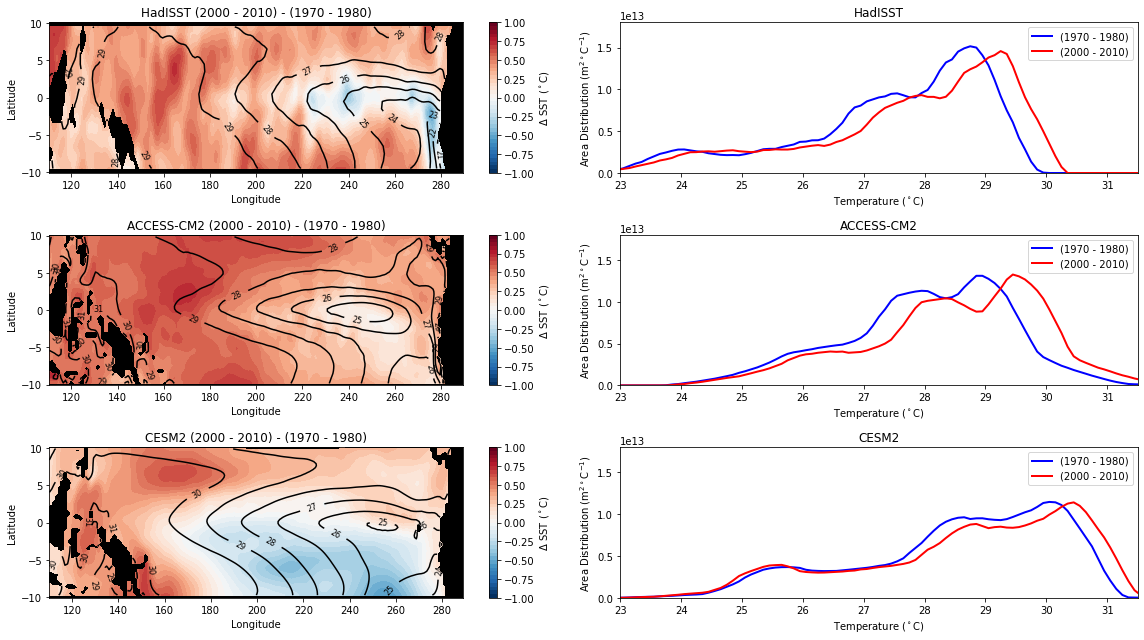

In [13]:
# Plot a few different runs (Historical) against observations:
models = ['HadISST','ACCESS-CM2','CESM2']#,'GFDL-CM4']
exp = 'His'
#time_bef = '1944-01-01','1974-01-01'
#time_aft = '1984-01-01','2014-01-01'
time_bef = '1970-01-01','1980-01-01'
time_aft = '2000-01-01','2010-01-01'
bef_label = '(' + time_bef[0][:4] + ' - ' + time_bef[1][:4] + ')'
aft_label = '(' + time_aft[0][:4] + ' - ' + time_aft[1][:4] + ')'

fig,axes = plt.subplots(nrows=len(models),ncols=2,facecolor='w',figsize=(16,9))

for i, run in enumerate(models):
    print(run)
    if (run == 'HadISST'):
        tos_bef, adist_bef = get_tos_adist_obs(HadISST.sst,HadISST.area,time_bef,xreg,yreg)
        tos_aft, adist_aft = get_tos_adist_obs(HadISST.sst,HadISST.area,time_aft,xreg,yreg)
    else:
        tos_bef, adist_bef = get_tos_adist(run,exp,time_bef,xreg,yreg)
        tos_aft, adist_aft = get_tos_adist(run,exp,time_aft,xreg,yreg)

    #(tos_aft-tos_bef).plot.contourf(ax=axes[i][0],levels=np.arange(0.,1.05,0.05),cmap=cm.cm.matter,x=tos_aft.attrs['lon_name'],y=tos_aft.attrs['lat_name'],cbar_kwargs={'label':'$\Delta$ SST ($^\circ$C)'})
    (tos_aft-tos_bef).plot.contourf(ax=axes[i][0],levels=np.arange(-1.0,1.05,0.05),cmap='RdBu_r',x=tos_aft.attrs['lon_name'],y=tos_aft.attrs['lat_name'],cbar_kwargs={'label':'$\Delta$ SST ($^\circ$C)'})
    #tos_aft.plot.contour(ax=axes[i][0],levels=[28.],colors='w',linestyles='dashed',x=tos_aft.attrs['lon_name'],y=tos_aft.attrs['lat_name'])
    CS = tos_aft.plot.contour(ax=axes[i][0],levels=np.arange(0.,36.,1.),colors='k',x=tos_aft.attrs['lon_name'],y=tos_aft.attrs['lat_name'])
    axes[i][0].clabel(CS,CS.levels,inline=True, fontsize=8)
    
    # Apply a smoothing:
    adist_bef = adist_bef.rolling(temperature=smth, center=True).mean()
    adist_aft = adist_aft.rolling(temperature=smth, center=True).mean()
    
    adist_bef.plot(ax=axes[i][1],label=bef_label,color='b',linewidth=2)
    adist_aft.plot(ax=axes[i][1],label=aft_label,color='r',linewidth=2)
    aft_mean = (adist_aft*adist_aft.temperature).sum('temperature')/adist_aft.sum('temperature')
    bef_mean = (adist_bef*adist_bef.temperature).sum('temperature')/adist_bef.sum('temperature')
    aft_std = np.sqrt((adist_aft*(adist_aft.temperature-aft_mean)**2.0).sum('temperature')/adist_aft.sum('temperature'))
    bef_std = np.sqrt((adist_bef*(adist_bef.temperature-bef_mean)**2.0).sum('temperature')/adist_bef.sum('temperature'))
    print('Early Mean: ' + str(bef_mean.values) + ' Early Std: ' + str(bef_std.values))
    print('Late Mean: ' + str(aft_mean.values) + ' Late Std: ' + str(aft_std.values))
    #axes[i][1].plot([x-bef_mean+aft_mean for x in adist_bef.temperature.values],adist_bef.values,'--b',label=bef_label + ' mean-shifted')
    
    yp = 0.1e13,0.3e13
    #axes[i][1].plot([bef_mean,bef_mean],yp,'-b')
    #axes[i][1].plot([bef_mean+bef_std,bef_mean+bef_std],yp,'-b')
    #axes[i][1].plot([bef_mean-bef_std,bef_mean-bef_std],yp,'-b')
    #axes[i][1].plot([bef_mean-bef_std,bef_mean+bef_std],[(yp[0]+yp[1])/2.,(yp[0]+yp[1])/2.],'-b')
    yp = 0.4e13,0.6e13
    #axes[i][1].plot([aft_mean,aft_mean],yp,'-r')
    #axes[i][1].plot([aft_mean+aft_std,aft_mean+aft_std],yp,'-r')
    #axes[i][1].plot([aft_mean-aft_std,aft_mean-aft_std],yp,'-r')
    #axes[i][1].plot([aft_mean-aft_std,aft_mean+aft_std],[(yp[0]+yp[1])/2.,(yp[0]+yp[1])/2.],'-r')    
    yp = 0.7e13,0.9e13
    #axes[i][1].plot([aft_mean,aft_mean],yp,'--b')
    #axes[i][1].plot([aft_mean+bef_std,aft_mean+bef_std],yp,'--b')
    #axes[i][1].plot([aft_mean-bef_std,aft_mean-bef_std],yp,'--b')
    #axes[i][1].plot([aft_mean-bef_std,aft_mean+bef_std],[(yp[0]+yp[1])/2.,(yp[0]+yp[1])/2.],'--b')

    axes[i][0].set_title(run + ' ' + aft_label + ' - ' + bef_label)# + ' (with ' + aft_label + ' mean contours)')  
    axes[i][1].set_title(run)
    
    axes[i][0].set_facecolor('k')
    axes[i][0].set_xlabel('Longitude')
    axes[i][0].set_ylabel('Latitude')
    axes[i][0].set_ylim([-10.1,10.1])
    axes[i][1].legend()
    axes[i][1].set_xlim([23.,31.5])
    axes[i][1].set_ylim([0.,1.8e13])
    axes[i][1].set_xlabel('Temperature ($^\circ$C)')
    axes[i][1].set_ylabel('Area Distribution (m$^2$$^\circ$C$^{-1}$)')
    
plt.tight_layout()
plt.savefig('Historical_10year_TropPacTrends_HadISST_CM2_CESM2_noshiftbars.png',dpi=100,bbox_inches='tight')

In [ ]:
# Plot Mean state bias
models = ['HadISST','ACCESS-CM2','CESM2']
exp = 'His'
time_aft = '1984-01-01','2014-01-01'
aft_label = '(' + time_aft[0][:4] + ' - ' + time_aft[1][:4] + ')'

fig,axes = plt.subplots(nrows=len(models),ncols=1,facecolor='w',figsize=(8,9))

tos_obs, adist_obs = get_tos_adist_obs(HadISST.sst,HadISST.area,time_aft,xreg,yreg)

for i, run in enumerate(models[1:]):
    tos_aft, adist_aft = get_tos_adist(run,exp,time_aft,xreg,yreg)

    (tos_aft-tos_obs).plot.contourf(ax=axes[i][0],levels=np.arange(-1.0,1.05,0.05),cmap='RdBu_r',x=tos_aft.attrs['lon_name'],y=tos_aft.attrs['lat_name'],cbar_kwargs={'label':'$\Delta$ SST ($^\circ$C)'})
    CS = tos_aft.plot.contour(ax=axes[i][0],levels=np.arange(0.,36.,1.),colors='k',x=tos_aft.attrs['lon_name'],y=tos_aft.attrs['lat_name'])
    axes[i][0].clabel(CS,CS.levels,inline=True, fontsize=8)
    
    axes[i][0].set_title(run + ' ' + aft_label + ' - ' + bef_label)# + ' (with ' + aft_label + ' mean contours)')  
    axes[i][1].set_title(run)
    
    axes[i][0].set_facecolor('k')
    axes[i][0].set_xlabel('Longitude')
    axes[i][0].set_ylabel('Latitude')
    axes[i][0].set_ylim([-10.1,10.1])
    axes[i][1].legend()
    axes[i][1].set_xlim([23.,31.5])
    axes[i][1].set_ylim([0.,1.8e13])
    axes[i][1].set_xlabel('Temperature ($^\circ$C)')
    axes[i][1].set_ylabel('Area Distribution (m$^2$$^\circ$C$^{-1}$)')
    
plt.tight_layout()
plt.savefig('Historical_10year_TropPacTrends_HadISST_CM2_CESM2_noshiftbars.png',dpi=100,bbox_inches='tight')

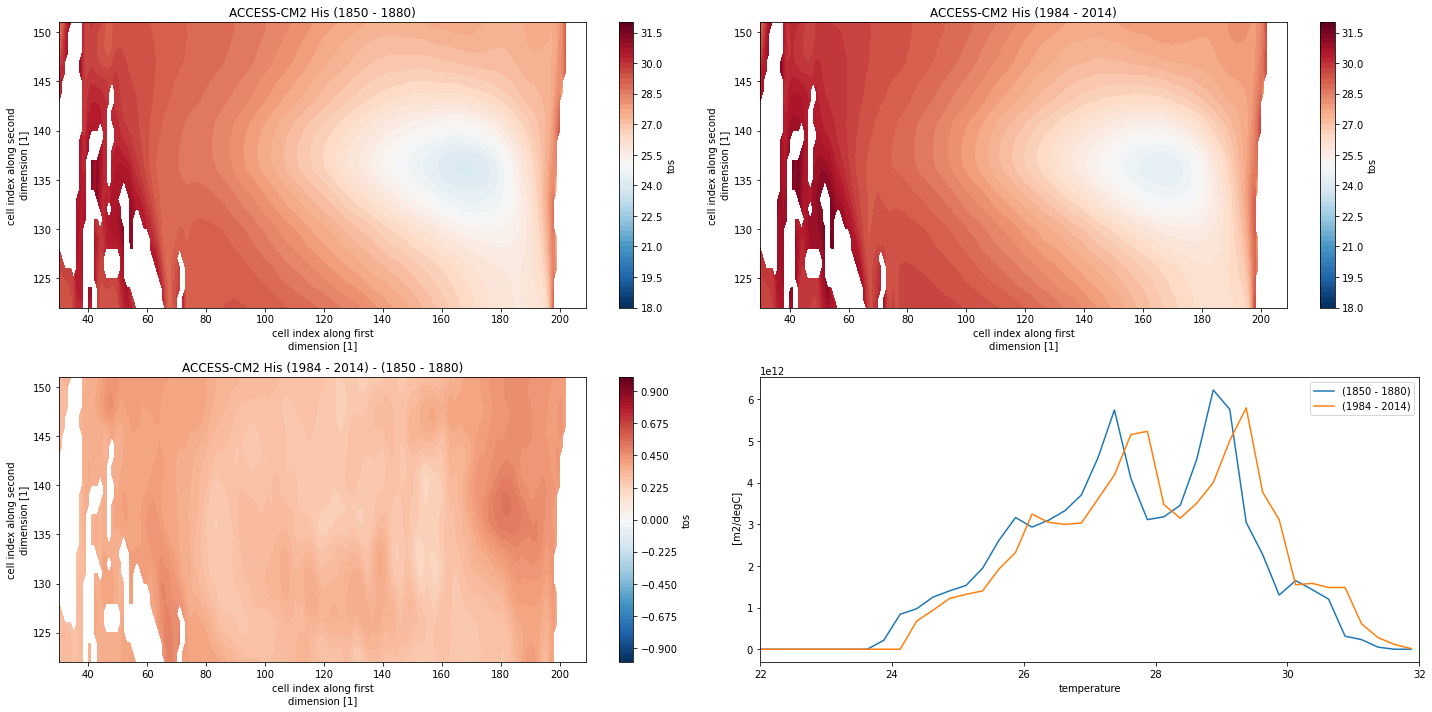

In [78]:
# ACCESS-CM2 historial run:
model = 'ACCESS-CM2 His'
exp = 'His'
time_bef = '1850-01-01','1880-01-01'
time_aft = '1984-01-01','2014-01-01'

tos_bef, adist_bef = get_tos_adist(model,exp,time_bef,xreg,yreg)
tos_aft, adist_aft = get_tos_adist(model,exp,time_aft,xreg,yreg)

bef_label = '(' + time_bef[0][:4] + ' - ' + time_bef[1][:4] + ')'
aft_label = '(' + time_aft[0][:4] + ' - ' + time_aft[1][:4] + ')'

fig,axes = plt.subplots(nrows=2,ncols=2,facecolor='w',figsize=(20,10))

tos_bef.plot.contourf(ax=axes[0][0],levels=Te,cmap='RdBu_r')
tos_aft.plot.contourf(ax=axes[0][1],levels=Te,cmap='RdBu_r')
(tos_aft-tos_bef).plot.contourf(ax=axes[1][0],levels=np.arange(-1.,1.025,0.025),cmap='RdBu_r')

adist_bef.plot(ax=axes[1][1],label=bef_label)
adist_aft.plot(ax=axes[1][1],label=aft_label)
axes[1][1].legend()
axes[1][1].set_xlim([22.,32.])

axes[0][0].set_title(run + ' ' + bef_label)
axes[0][1].set_title(run + ' ' + aft_label)
axes[1][0].set_title(run + ' ' + aft_label + ' - ' + bef_label)
#axes[0].set_clim([18.,31.])
plt.tight_layout()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


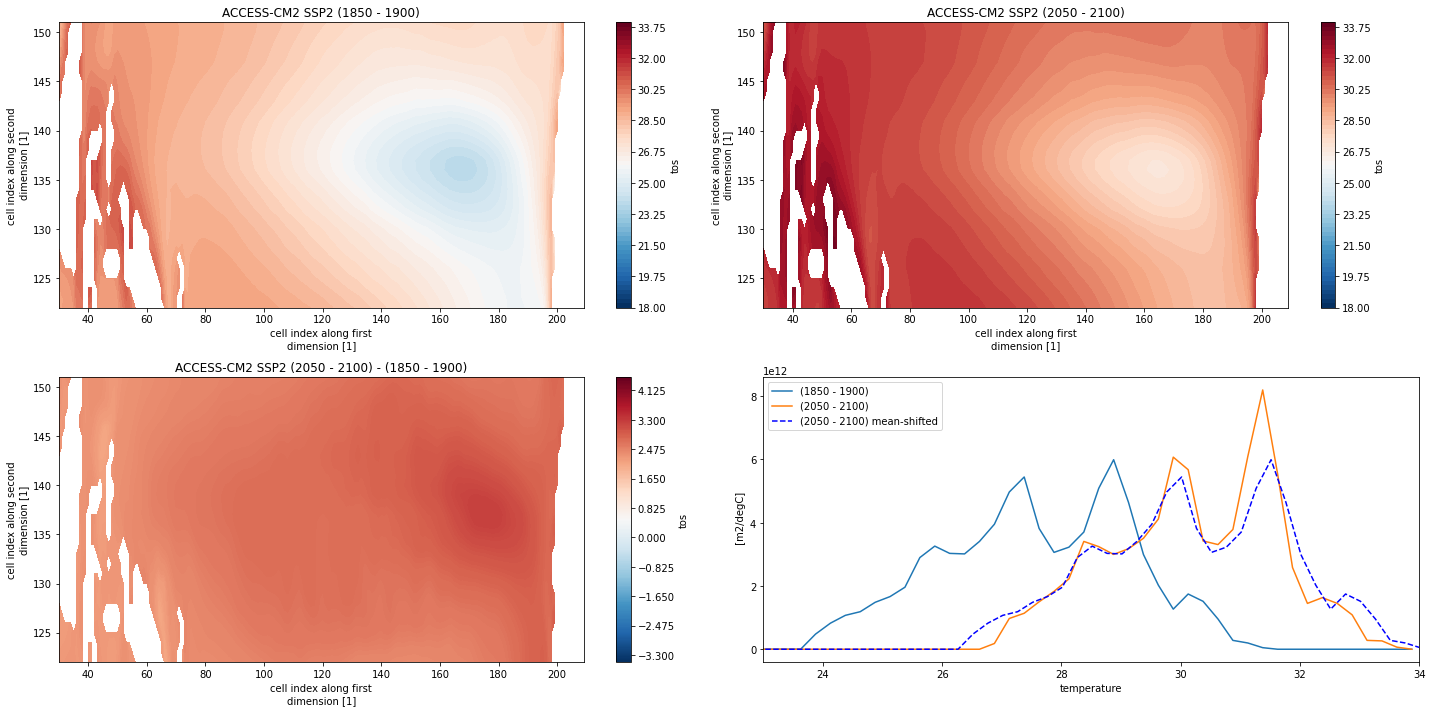

In [181]:
# Plot ScenarioMIP and historical for ACCESS-CM2:
time_bef = '1850-01-01','1900-01-01'
bef_label = '(' + time_bef[0][:4] + ' - ' + time_bef[1][:4] + ')'
tos_bef, adist_bef = get_tos_adist('ACCESS-CM2','His',time_bef,xreg,yreg)

time_aft = '2050-01-01','2100-01-01'
aft_label = '(' + time_aft[0][:4] + ' - ' + time_aft[1][:4] + ')'
tos_aft, adist_aft = get_tos_adist('ACCESS-CM2','SSP2',time_aft,xreg,yreg)

fig,axes = plt.subplots(nrows=2,ncols=2,facecolor='w',figsize=(20,10))

tos_bef.plot.contourf(ax=axes[0][0],levels=Te,cmap='RdBu_r')
tos_aft.plot.contourf(ax=axes[0][1],levels=Te,cmap='RdBu_r')
(tos_aft-tos_bef).plot.contourf(ax=axes[1][0],levels=np.arange(-3.5,4.525,0.025),cmap='RdBu_r')

adist_bef.plot(ax=axes[1][1],label=bef_label)
adist_aft.plot(ax=axes[1][1],label=aft_label)
aft_mean = (adist_aft*adist_aft.temperature).sum('temperature')/adist_aft.sum('temperature')
bef_mean = (adist_bef*adist_bef.temperature).sum('temperature')/adist_bef.sum('temperature')
axes[1][1].plot([x-bef_mean+aft_mean for x in adist_bef.temperature.values],adist_bef.values,'--b',label=aft_label + ' mean-shifted')

axes[1][1].legend()
axes[1][1].set_xlim([23.,34.])

axes[0][0].set_title(run + ' ' + bef_label)
axes[0][1].set_title(run + ' ' + aft_label)
axes[1][0].set_title(run + ' ' + aft_label + ' - ' + bef_label)
#axes[0].set_clim([18.,31.])
plt.tight_layout()

MPI-M


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


MRI


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


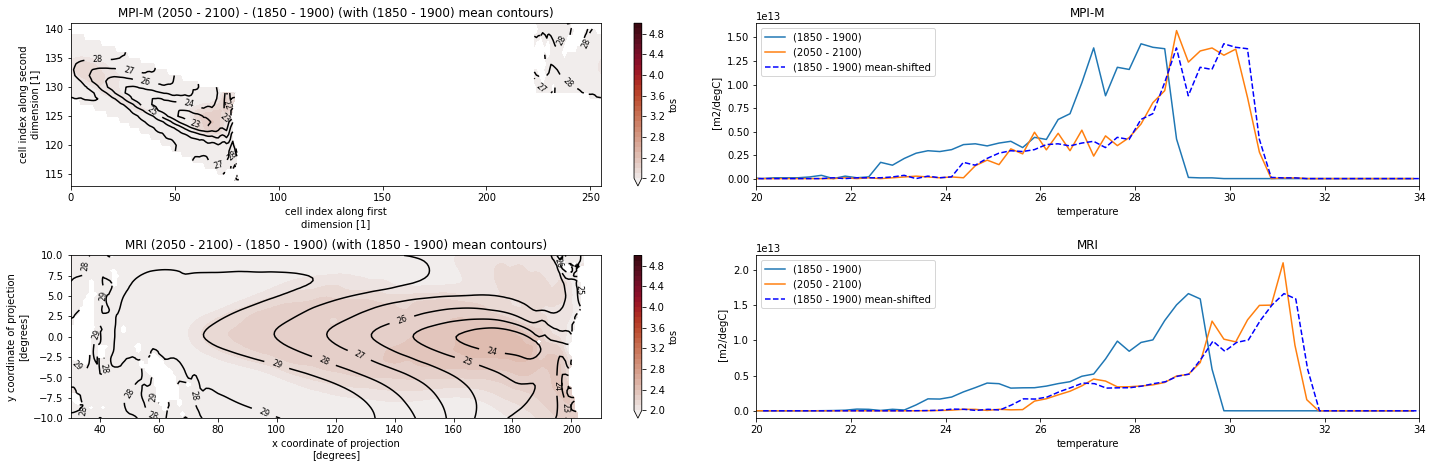

In [41]:
# Plot a few different runs (ScenarioMIP + Historical):
models = ['MIROC','MOHC']#['ACCESS-CM2','CESM2','NASA-GISS']#'GFDL-CM4']
models = ['MPI-M','MRI']
time_bef = '1850-01-01','1900-01-01'
time_aft = '2050-01-01','2100-01-01'
bef_label = '(' + time_bef[0][:4] + ' - ' + time_bef[1][:4] + ')'
aft_label = '(' + time_aft[0][:4] + ' - ' + time_aft[1][:4] + ')'

fig,axes = plt.subplots(nrows=len(models),ncols=2,facecolor='w',figsize=(20,6.6))

for i, run in enumerate(models):
    print(run)
    tos_bef, adist_bef = get_tos_adist(run,'His',time_bef,xreg,yreg)
    tos_aft, adist_aft = get_tos_adist(run,'SSP2',time_aft,xreg,yreg)

    (tos_aft-tos_bef).plot.contourf(ax=axes[i][0],levels=np.arange(2.,5.1,0.1),cmap=cm.cm.amp)
    CS = tos_bef.plot.contour(ax=axes[i][0],levels=np.arange(0.,36.,1.),colors='k')
    axes[i][0].clabel(CS,CS.levels,inline=True, fontsize=8)
    
    adist_bef.plot(ax=axes[i][1],label=bef_label)
    adist_aft.plot(ax=axes[i][1],label=aft_label)
    aft_mean = (adist_aft*adist_aft.temperature).sum('temperature')/adist_aft.sum('temperature')
    bef_mean = (adist_bef*adist_bef.temperature).sum('temperature')/adist_bef.sum('temperature')
    axes[i][1].plot([x-bef_mean+aft_mean for x in adist_bef.temperature.values],adist_bef.values,'--b',label=bef_label + ' mean-shifted')

    axes[i][1].legend()
    axes[i][1].set_xlim([20.,34.])
    axes[i][0].set_title(run + ' ' + aft_label + ' - ' + bef_label + ' (with ' + bef_label + ' mean contours)')  
    axes[i][1].set_title(run)
plt.tight_layout()
plt.savefig('SSP2_30year_TropPacTrends_MPI_MRI.png',dpi=100,bbox_inches='tight')

(18.0, 31.0)

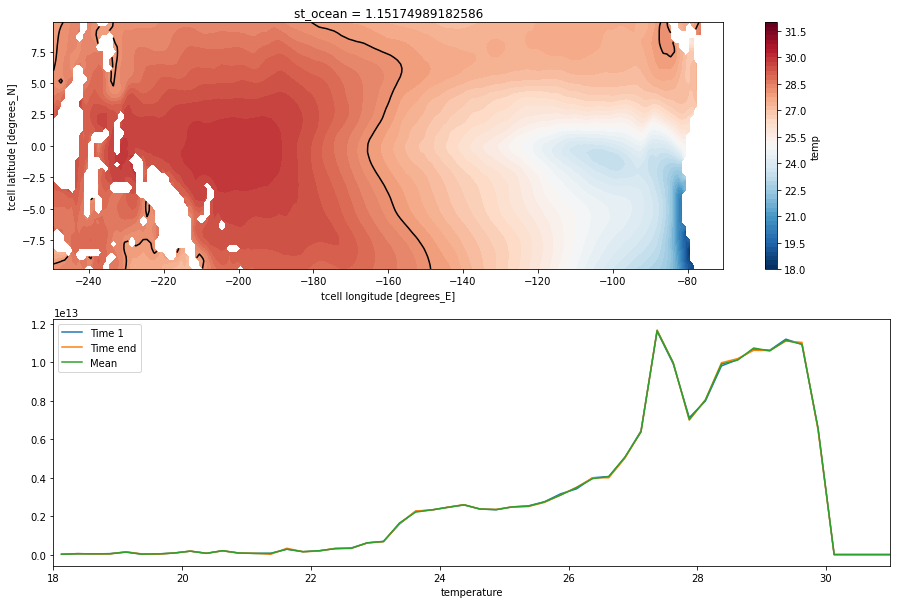

In [115]:
# Test on ACCESS-OM2 data:
TP_sst = fnames.temp.isel(st_ocean=0).sel(xt_ocean=slice(xreg[0],xreg[1])).sel(yt_ocean=slice(yreg[0],yreg[1]))-273.15
area_t = gnames.area_t.sel(xt_ocean=slice(xreg[0],xreg[1])).sel(yt_ocean=slice(yreg[0],yreg[1]))

fig,axes = plt.subplots(nrows=2,ncols=1,facecolor='w',figsize=(15,10))

TP_sst.mean('time').plot.contourf(ax=axes[0],levels=Te,cmap='RdBu_r')
TP_sst.mean('time').plot.contour(ax=axes[0],levels=[28.],colors='k')

SST_adist = calc_Adist(TP_sst)
SST_adist.isel(time=0).plot(ax=axes[1],label='Time 1')
SST_adist.isel(time=-1).plot(ax=axes[1],label='Time end')
SST_adist.mean('time').plot(ax=axes[1],label='Mean')
axes[1].legend()
axes[1].set_xlim([18.,31.])
#axes[0].set_clim([18.,31.])

In [33]:
model = 'MIROC'
exp = 'His'
times = '1850-01-01','1900-01-01'

run = model + ' ' + exp
tos_name = runs[run]['base'] + '/' + runs[run]['model'] + '/' + runs[run]['exp'] + '/' + \
       runs[run]['version'] + '/Omon/tos/gn/' + runs[run]['version2'] + '/*.nc'

tos = xr.open_mfdataset(tos_name).tos.sel(time=slice(times[0],times[1])).mean('time')

area_name = areas[model]['base'] + '/' + areas[model]['model'] + '/' + areas[model]['exp'] + '/' + \
                areas[model]['version'] + '/Ofx/areacello/gn/' + areas[model]['version2'] + '/*.nc'
area = xr.open_mfdataset(area_name).areacello

try:
    if (np.amin(tos.longitude.values[:])<0.):
        lon_adj = 0.
    else:
        lon_adj = 360.

    tos = tos.where((tos.latitude)>=yreg[0], drop=True).where((tos.latitude)<=yreg[1], drop=True)
    tos = tos.where((tos.longitude-lon_adj)>=xreg[0], drop=True).where((tos.longitude-lon_adj)<=xreg[1], drop=True)
    area = area.where((area.latitude)>=yreg[0], drop=True).where((area.latitude)<=yreg[1], drop=True)
    area = area.where((area.longitude-lon_adj)>=xreg[0], drop=True).where((area.longitude-lon_adj)<=xreg[1], drop=True)
except:
    if (np.amin(tos.lon.values[:])<0.):
        lon_adj = 0.
    else:
        lon_adj = 360.
    tos = tos.where((tos.lat)>=yreg[0], drop=True).where((tos.lat)<=yreg[1], drop=True)
    tos = tos.where((tos.lon-lon_adj)>=xreg[0], drop=True).where((tos.lon-lon_adj)<=xreg[1], drop=True)
    area = area.where((area.lat)>=yreg[0], drop=True).where((area.lat)<=yreg[1], drop=True)
    area = area.where((area.lon-lon_adj)>=xreg[0], drop=True).where((area.lon-lon_adj)<=xreg[1], drop=True)
#tos.assign_coords(i=tos.longitude.isel(j=0).values).assign_coords(j=tos.latitude.isel(i=0).values)

#adist = calc_Adist(tos,area)

In [35]:
tos

<xarray.DataArray 'tos' (y: 34, x: 180)>
dask.array<where, shape=(34, 180), dtype=float32, chunksize=(34, 180), chunktype=numpy.ndarray>
Coordinates:
  * x          (x) float64 50.5 51.5 52.5 53.5 54.5 ... 226.5 227.5 228.5 229.5
  * y          (y) float64 -9.157 -8.326 -7.558 -6.855 ... 7.988 8.756 9.587
    latitude   (y, x) float32 -9.157 -9.157 -9.157 -9.157 ... 9.587 9.587 9.587
    longitude  (y, x) float32 110.5 111.5 112.5 113.5 ... 287.5 288.5 289.5

In [18]:
area_name = runs[run]['base'] + '/' + runs[run]['model'] + '/' + runs[run]['exp'] + '/' + \
                runs[run]['version'] + '/Ofx/areacello/gn/' + runs[run]['version2'] + '/*.nc'
area = xr.open_mfdataset(area_name).areacello

OSError: no files to open